In [9]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98;} </style>"))

### **Overview**
A typical RAG application has two main components:

- Indexing: a pipeline for ingesting data from a source and indexing it. This usually happens offline.

- Retrieval and generation: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.

### **Indexing**
- Load: First we need to load our data. This is done with Document Loaders.
- Split: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and passing it into a model, as large chunks are harder to search over and won't fit in a model's finite context window.
- Store: We need somewhere to store and index our splits, so that they can be searched over later. This is often done using a VectorStore and Embeddings model.

Once we've indexed our data, we will use LangGraph as our orchestration framework to implement the retrieval and generation steps.

### __Retrieval and generation__
- Retrieve: Given a user input, relevant splits are retrieved from storage using a Retriever.
- Generate: A ChatModel / LLM produces an answer using a prompt that includes both the question with the retrieved data

In [10]:
#%pip install ipywidgets
#%pip install python-dotenv
#%pip install langchain
#%pip install --quiet --upgrade langchain-core langsmith langchain-text-splitters langchain-community langgraph 

### __LangSmith__

In [11]:
from dotenv import load_dotenv
import os

# Carga las variables desde el fichero .env en el directorio actual
load_dotenv()

api_key = os.getenv("LANGSMITH_API_KEY")
if api_key:
    print("Clave de LangSmith cargada correctamente")
else:
    print("No se encontró la clave de LangSmith")

Clave de LangSmith cargada correctamente


### __Components__

#### __1. Select LLM Model__

In [12]:
#%pip install -U transformers
#%pip install -U langchain-ollama
#%pip install ollama

- Para descargar una versión local del modelo LLM hay que instalar Ollama desde: https://ollama.com/download
- Después ejecutar los siguientes comandos en powershell o cmd después de añadir Ollama al PATH del sistema:
  1. 'ollama run hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0' en una terminal que funciona como servidor.
  2. Para ver detalles del modelo: .\ollama.exe list
- Es un modelo de 3B de parámetros y 8 bits.

https://huggingface.co/bartowski/Llama-3.2-3B-Instruct-GGUF

In [8]:
from langchain_ollama import OllamaLLM
# ollama run hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0
llm = OllamaLLM(model="hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0") 
print(llm.invoke("Dime algo curioso sobre el imperio romano"))

El Imperio Romano fue un vasto y complejo estado que se extendió durante varias centurias, dejando una profunda huella en la historia de Europa y más allá. Uno de los aspectos más fascinantes del Imperio Romano es su sistema de "cursus honorum", que era el camino que debían seguir las personas para ascender en el rango administrativo y militar del imperio. Este cursus honorum era estructurado en varios grados y se iniciaba con cargos menores, pero con creciente responsabilidad y prestigio.

En este sistema, los nuevos candidatos al servicio público o a la carrera militar debían comenzar como "centuriones", un cargo que equivalía aproximadamente a un teniente. A medida que avanzaban en su carrera, podían promocionarse a "tribuno", luego a "gobernador" de una provincia y finalmente a magistrado romano o gobernante del imperio.

El sistema era tan riguroso que incluso los filósofos y intelectuales no estaban exentos de su influencia. Platón, por ejemplo, tuvo que servir en el ejército rom

#### __2. Select Embeddings Model__

In [14]:
#%pip install -qU langchain-huggingface
#%pip install sentence-transformers
#%pip install huggingface_hub[hf_xet]

https://huggingface.co/Qwen/Qwen3-Embedding-4B
https://huggingface.co/spaces/mteb/leaderboard

In [15]:
'''
from sentence_transformers import SentenceTransformer
model_embbedings = SentenceTransformer("Qwen/Qwen3-Embedding-4B")
'''

'\nfrom sentence_transformers import SentenceTransformer\nmodel_embbedings = SentenceTransformer("Qwen/Qwen3-Embedding-4B")\n'

Este modelo es demasiado grande, por lo que decidimos cambiar a uno más pequeño.

In [9]:
# Modelo más pequeño
from langchain_huggingface import HuggingFaceEmbeddings

model_embbedings_mini = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
print("Modelo de Embeddings inicializado") # mirar sus parametros

Modelo de Embeddings inicializado


In [10]:
# Verifica dimensiones del modelo
test_embedding = model_embbedings_mini.embed_query("test")
if len(test_embedding) != 384:
    raise ValueError(f"Modelo {model_embbedings_mini} produce vectores de dimensión {len(test_embedding)}. Debe ser 384.")


Comprobamos que la longitud de los vectores es 384.

#### __3. Select Vector Store__

In [17]:
#%pip install -qU langchain-qdrant

Primero, inicializamos Qdrant en memoria para realizar pruebas.

In [18]:
'''
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance
from langchain_qdrant import QdrantVectorStore

# Inicializar Qdrant en memoria para realizar pruebas
client = QdrantClient(":memory:")

vector_store = QdrantVectorStore(
    client=client,
    collection_name="test",
    embedding=model_embeddings
)

print("Vector store creado en memoria")
'''

'\nfrom qdrant_client import QdrantClient\nfrom qdrant_client.models import VectorParams, Distance\nfrom langchain_qdrant import QdrantVectorStore\n\n# Inicializar Qdrant en memoria para realizar pruebas\nclient = QdrantClient(":memory:")\n\nvector_store = QdrantVectorStore(\n    client=client,\n    collection_name="test",\n    embedding=model_embeddings\n)\n\nprint("Vector store creado en memoria")\n'

In [1]:
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams
# BORRAMOS Y VOLVEMOS A SUBIR LA COLECCIÓN POR PROBLEMAS EN EL TAMAÑO DE VECTORES
# DOCKER
# Configuración
COLLECTION_NAME = "idearq"
VECTOR_SIZE = 384
model_embbedings_mini = "all-MiniLM-L6-v2"  # 384 dimensiones

# Inicializar clientes
client = QdrantClient(url="http://localhost:6333")

# 1. Borrar colección (si ya existe)
if COLLECTION_NAME in [c.name for c in client.get_collections().collections]:
    client.delete_collection(COLLECTION_NAME)

# 2. Crear colección
client.recreate_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE),
)

# cambio distance.dot a coseno porque es más recomendable en texto
# size a 384 porque es el tamaño de los embbedings de all-MiniLM-L6-v2

C:\Users\elevi\AppData\Local\Temp\ipykernel_9576\2942919570.py:18: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [11]:
client = QdrantClient(url="http://localhost:6333")
info = client.get_collection(COLLECTION_NAME)
assert info.config.params.vectors.size == 384, "La colección no está configurada para vectores de 384 dimensiones."
print("¡La dimensión de los vectores (384) es correcta!")

¡La dimensión de los vectores (384) es correcta!


Cuando convertimos texto a embeddings, lo que nos importa es el "significado" o "dirección" del texto, no cuánto "mide" el vector, por eso escogemos la similitud del coseno. Dos frases con significado similar tendrán vectores que apuntan en la misma dirección, resultando en una similitud de coseno cercana a 1.
Rango: de -1 (opuestos) a 1 (idénticos).

## __Indexing__

### __Loading__

In [20]:
# TEST DE CARGA DE PDFS
from pathlib import Path
import re
from langchain.document_loaders import PyPDFLoader, PyMuPDFLoader

pdf_dir = Path("pdf_test/")
pdf_files = list(pdf_dir.glob("*.pdf"))

results = {}

for loader_name, loader_class in {
    "PyPDFLoader": lambda path:PyPDFLoader(path, mode="single"),
    "PyMuPDFLoader": lambda path: PyMuPDFLoader(path, mode="single")
}.items():
    total_docs = 0
    total_length = 0
    for pdf_file in pdf_files:
        try:
            loader = loader_class(str(pdf_file))
            docs = loader.load()
            total_docs += len(docs)
            total_length += sum(len(doc.page_content) for doc in docs)
        except Exception as e:
            print(f"Error con {loader_name} en {pdf_file.name}: {e}")
    avg_length = total_length / total_docs if total_docs else 0
    results[loader_name] = {
        "n_docs": total_docs,
        "avg_length": round(avg_length, 2)
    }

for name, stats in results.items():
    print(f"{name}: {stats['n_docs']} documentos, longitud media {stats['avg_length']} caracteres")


PyPDFLoader: 11 documentos, longitud media 60469.36 caracteres
PyMuPDFLoader: 11 documentos, longitud media 60264.0 caracteres


In [21]:
# TEST DE CARGA DE PDFS SIN COMPARAR PERO CON MÁS EJEMPLOS
import re
from langchain.document_loaders import PyPDFLoader, PyMuPDFLoader
# Cargar PDFs de forma normal sin comparar
folder_path = Path("pdf_test/")
pdf_files = list(folder_path.glob("*.pdf"))

# Cargar todos los PDFs
all_docs = []
for pdf_file in pdf_files:
    loader = PyMuPDFLoader(str(pdf_file), mode="single") # mode="page" divide los documentos por página
    docs = loader.load()
    all_docs.extend(docs)

print(f"Se cargaron {len(all_docs)} documentos")

Se cargaron 11 documentos


In [20]:
import logging
from pathlib import Path
from langchain.document_loaders import PyMuPDFLoader

# Asegúrate de que el logging esté configurado
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Carga robusta de documentos desde un directorio local ---

all_docs = []
folder_path = Path("pdf_articulos_idearq/") # La ruta a tu carpeta de PDFs

logging.info(f"Iniciando la carga de documentos desde: {folder_path.resolve()}")

if not folder_path.is_dir():
    logging.error(f"El directorio especificado no existe: {folder_path.resolve()}")
else:
    # Usamos .glob() que es eficiente para buscar archivos
    for pdf_file in folder_path.glob("*.pdf"):
        try:
            loader = PyMuPDFLoader(str(pdf_file), mode="single")
            docs_from_file = loader.load()
            all_docs.extend(docs_from_file)
            # logging.debug(f"Cargado: {pdf_file.name}") # Descomenta para ver cada archivo
        except Exception as e:
            # Este bloque capturará si un PDF específico está dañado y no se puede leer
            logging.warning(f"No se pudo cargar el archivo '{pdf_file.name}'. Saltando. Error: {e}")

    logging.info(f"Carga finalizada. Se han cargado un total de {len(all_docs)} documentos.")

Me decanto por PyMuPDFLoader porque es más flexible frente a PDFs con estructuras complejas, en cambio PyPDF es demasiado estricto y no puede gestionar algunos PDFs, desembocando en errores.

Para ver metadatos de un artículo:

In [ ]:
import pprint # REVISAR
# Para inspeccionar los metadatos del primer documento cargado (sin sobreescribir all_docs)\n",
if all_docs:
    print("--- Metadatos del primer documento cargado en la celda anterior ---")
else:
    print("La variable 'all_docs' está vacía.")
   

{'producer': '',
 'creator': '',
 'creationdate': '',
 'source': 'pdf_articulos_idearq\\Objetos y personas_ la necrópolis de Cerro '
           'Colorado y la -- Dionisio Urbina Martínez, Catalina Urquijo '
           'Álvarez de Toledo -- 1, 2015 -- Consejo -- 9788400100278 -- '
           '8b32b0353860092e0fceccc5006bfbd8 -- Anna’s.pdf',
 'file_path': 'pdf_articulos_idearq\\Objetos y personas_ la necrópolis de '
              'Cerro Colorado y la -- Dionisio Urbina Martínez, Catalina '
              'Urquijo Álvarez de Toledo -- 1, 2015 -- Consejo -- '
              '9788400100278 -- 8b32b0353860092e0fceccc5006bfbd8 -- Anna’s.pdf',
 'total_pages': 0,
 'format': 'PDF 1.6',
 'title': '',
 'author': '',
 'subject': '',
 'keywords': '',
 'moddate': '',
 'trapped': '',
 'modDate': '',
 'creationDate': ''}


### __Splitting__

https://python.langchain.com/docs/tutorials/retrievers/
https://python.langchain.com/docs/tutorials/rag/
https://qdrant.tech/documentation/quickstart/
https://python.langchain.com/docs/integrations/document_loaders/pypdfloader/

In [ ]:
# TEST DE SPLIT DE TEXTO
from langchain_text_splitters import RecursiveCharacterTextSplitter
# tutorial langchain
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(all_docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [21]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import logging

# Configurar un logger para controlar el proceso
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

text_splitter_config = {
    "chunk_size": 1000,
    "chunk_overlap": 200, # 15-20% de chunk_size
    "length_function": len,
    "add_start_index": True,
    "separators": ["\n\n", "\n", ". ", " ", ""],
}

# El operador ** desempaqueta el diccionario como argumentos 
text_splitter = RecursiveCharacterTextSplitter(**text_splitter_config)

all_splits = text_splitter.split_documents(all_docs)

logging.info(f"Se dividieron {len(all_docs)} documentos en un total de {len(all_splits)} chunks.")

In [ ]:
# revisar uno o dos chunks para asegurar que el splitting es lógico
if all_splits:
    logging.info("Ejemplo del primer chunk generado:")
    print(all_splits[0].page_content)
    logging.info("Metadatos del primer chunk:")
    pprint.pp(all_splits[0].metadata)


2025-07-16 12:31:41,337 - INFO - Ejemplo del primer chunk generado:
2025-07-16 12:31:41,338 - INFO - Metadatos del primer chunk:


Full Terms & Conditions of access and use can be found at
http://www.tandfonline.com/action/journalInformation?journalCode=yjfa20
Download by: [University of Newcastle, Australia]
Date: 20 February 2017, At: 04:16
Journal of Field Archaeology
ISSN: 0093-4690 (Print) 2042-4582 (Online) Journal homepage: http://www.tandfonline.com/loi/yjfa20
First Evidence of Collective Human Inhumation
from the Cardial Neolithic (Cova Bonica, Barcelona,
NE Iberian Peninsula)
F. Xavier Oms, Joan Daura, Montserrat Sanz, Susana Mendiela, Mireia Pedro
& Pablo Martínez
To cite this article: F. Xavier Oms, Joan Daura, Montserrat Sanz, Susana Mendiela, Mireia Pedro
& Pablo Martínez (2017) First Evidence of Collective Human Inhumation from the Cardial Neolithic
(Cova Bonica, Barcelona, NE Iberian Peninsula), Journal of Field Archaeology, 42:1, 43-53, DOI:
10.1080/00934690.2016.1260407
To link to this article:  http://dx.doi.org/10.1080/00934690.2016.1260407
Published online: 13 Feb 2017.
{'producer': 'iText 4.2

- RecursiveCharacterTextSplitter: Intenta mantener párrafos y frases juntas, lo cual es puede ser mejor que un corte abrupto por caracteres. Hay otro splitters pero son para código o Markdown.
- chunk_size=1000, chunk_overlap=200: El solapamiento (overlap) es crucial para no perder contexto en los límites de cada trozo de texto (chunk).
add_start_index=True: Se utiliza para depuración y para saber de qué parte del documento original proviene cada chunk.

https://python.langchain.com/docs/integrations/document_loaders/grobid/

En principio, estos parámetros son los recomendables en RAGs con modelos pequeños. Se podría subir chunk_size a 1500 si las respuestas pierden contexto, aunque un tamaño de 1000 permite respuestas más específicas.

From langchain: We set add_start_index=True so that the character index where each split Document starts within the initial Document is preserved as metadata attribute “start_index”.

Podríamos hacer otro tipo de split, que es el split semántico: https://python.langchain.com/docs/how_to/semantic-chunker/

### __Embeddings and Storing__

Primero, se encuentran las celdas de testeo

In [ ]:
vector_1 = embedding.embed_query(all_splits[0].page_content)
vector_2 = embedding.embed_query(all_splits[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])

Generated vectors of length 2560

[-0.0002388065040577203, 0.06825609505176544, 0.004310491029173136, -0.00017211480007972568, -0.0008121936116367579, 0.04217046499252319, -0.03311644122004509, 0.018160805106163025, 0.001344389165751636, 0.025389451533555984]


In [ ]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['d38699d2eb6d4cbaa287913d21a7fa88', 'c222a4adef654922860e484550638b83', 'd3aece0f9eb349199ce90380ccb38807']


In [17]:
from langchain_qdrant import Qdrant
import logging
from langchain_core.embeddings import Embeddings 

QDRANT_URL = "http://localhost:6333"
COLLECTION_NAME = "idearq"
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)

# Configura el logger si no lo has hecho en una celda anterior.
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

client = QdrantClient(url=QDRANT_URL)

logging.info(f"Conectando a la colección '{COLLECTION_NAME}' a través de LangChain...")

vector_store = Qdrant(
    client=client,
    collection_name=COLLECTION_NAME,
    embeddings=embeddings,
)

2025-07-18 11:16:30,515 - INFO - Use pytorch device_name: cpu
2025-07-18 11:16:30,517 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2025-07-18 11:16:42,554 - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-07-18 11:16:42,557 - INFO - Conectando a la colección 'idearq' a través de LangChain...
C:\Users\elevi\AppData\Local\Temp\ipykernel_9576\1640482091.py:17: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.1.2 and will be removed in 0.5.0. Use :class:`~QdrantVectorStore` instead.
  vector_store = Qdrant(


In [20]:
from langchain_qdrant import Qdrant

QDRANT_URL = "http://localhost:6333"
COLLECTION_NAME = "idearq"

# Configura el logger si no lo has hecho en una celda anterior.
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 3. CREAR EL OBJETO 'vector_store' 
# Primero, nos conectamos al cliente de Qdrant 
client = QdrantClient(url=QDRANT_URL)

# Ahora, creamos la variable 'vector_store', que es el objeto de LangChain
# Este objeto "envuelve" al cliente y sabe cómo usar la función de embeddings
logging.info(f"Conectando a la colección '{COLLECTION_NAME}' a través de LangChain...")
vector_store = Qdrant(
    client=client,
    collection_name=COLLECTION_NAME,
    embeddings=embeddings,
)
logging.info("Objeto 'vector_store' listo para la ingesta")

# 4. INGESTA DE DOCUMENTOS 
logging.info(f"Iniciando la ingesta de {len(all_splits)} chunks...")

vector_store.add_documents(all_splits)

logging.info("Ingesta completada")


2025-07-18 11:24:42,733 - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-07-18 11:24:42,736 - INFO - Conectando a la colección 'idearq' a través de LangChain...
2025-07-18 11:24:42,737 - INFO - Objeto 'vector_store' listo para la ingesta
2025-07-18 11:24:42,739 - INFO - Iniciando la ingesta de 50687 chunks...
2025-07-18 11:24:45,525 - INFO - HTTP Request: PUT http://localhost:6333/collections/idearq/points?wait=true "HTTP/1.1 200 OK"
2025-07-18 11:24:47,996 - INFO - HTTP Request: PUT http://localhost:6333/collections/idearq/points?wait=true "HTTP/1.1 200 OK"
2025-07-18 11:24:50,517 - INFO - HTTP Request: PUT http://localhost:6333/collections/idearq/points?wait=true "HTTP/1.1 200 OK"
2025-07-18 11:24:52,874 - INFO - HTTP Request: PUT http://localhost:6333/collections/idearq/points?wait=true "HTTP/1.1 200 OK"
2025-07-18 11:24:55,323 - INFO - HTTP Request: PUT http://localhost:6333/collections/idearq/points?wait=true "HTTP/1.1 200 OK"
2025-07-18 11:24:57,670 - INFO 

In [22]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'producer': 'iText 4.2.0 by 1T3XT',
 'creator': 'Arbortext Advanced Print Publisher 10.0.1465/W Unicode',
 'creationdate': '2017-02-09T08:18:37+05:30',
 'source': 'pdf_articulos_idearq\\1000_oms_2017.pdf',
 'file_path': 'pdf_articulos_idearq\\1000_oms_2017.pdf',
 'total_pages': 12,
 'format': 'PDF 1.4',
 'title': 'First Evidence of Collective Human Inhumation from the Cardial Neolithic (Cova Bonica, Barcelona, NE Iberian Peninsula)',
 'author': 'F. Xavier Oms',
 'subject': 'Journal of Field Archaeology, 2016. doi:10.1080/00934690.2016.1260407',
 'keywords': '',
 'moddate': '2017-02-20T04:16:48-08:00',
 'trapped': '',
 'modDate': "D:20170220041648-08'00'",
 'creationDate': "D:20170209081837+05'30'",
 'start_index': 0,
 'section': 'beginning'}

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [2]:
# Verficación

from qdrant_client import QdrantClient
client = QdrantClient(url="http://localhost:6333")

COLLECTION_NAME = "idearq" 

print("\n--- Verificación en Qdrant ---")
print(f"Información de la colección '{COLLECTION_NAME}':")

# Usamos client.count() para obtener el número exacto de vectores
try:
    count_result = client.count(
        collection_name=COLLECTION_NAME, 
        exact=True
    )
    
    total_vectors = count_result.count
    
    if 'all_splits' in locals():
      print(f" - Chunks procesados en esta ejecución: {len(all_splits)}")

    print(f" - Número TOTAL de vectores en la colección: {total_vectors}")

except Exception as e:
    print(f"No se pudo obtener el conteo de la colección '{COLLECTION_NAME}'. Error: {e}")



--- Verificación en Qdrant ---
Información de la colección 'idearq':
 - Número TOTAL de vectores en la colección: 50687


### __Usage__

In [ ]:
# Devuelve los k documentos cuyos vectores son matemáticamente más cercanos (más similares) al vector de la pregunta
query = "Fortificación ibérica de Giribaile"

# Búsqueda de similitud
results = vector_store.similarity_search(query)

print(f"Búsqueda para: '{query}'\n")

if not results:
    print("No se encontraron documentos relevantes.")
else:
    # Iteramos sobre los resultados para verlos todos
    for i, doc in enumerate(results):
        print(f"--- Resultado {i+1} ---")
        
        print(doc.page_content)
        
        # Metadatos asociados
        if doc.metadata:
            print(f"\nMetadatos: {doc.metadata}")
            
        print("-" * (15 + len(str(i+1)))) 
        
        print() 


2025-07-16 14:05:12,491 - INFO - HTTP Request: POST http://localhost:6333/collections/idearq/points/query "HTTP/1.1 200 OK"


Búsqueda para: 'Fortificación ibérica de Giribaile'

--- Resultado 1 ---
acerca de aspectos relacionados con el supuesto carácter unitario del sistema defensivo y 
Figura 1.  Localización de Giribaile, en el pago de Cástulo.
L. M. Gutiérrez et al. ¿La fortificación ibérica de Giribaile? Caracterización formal e interpretación arquitectónica
38
PYRENAE, vol. 52 núm. 2 (2021)  ISSN: 0079-8215  EISSN: 2339-9171  (p. 35-60)
fijar criterios descriptivos precisos sobre la técnica de ejecución de los distintos elementos 
que lo conforman. 
Hasta ahora, el tramo más destacado de la defensa de Giribaile había concitado un 
interés muy limitado: la reseña realizada por Pierre Moret (1996: 518-519), como parte de 
su catálogo sobre fortificaciones protohistóricas de la península ibérica; un apartado general 
en el artículo dedicado al análisis de la topografía antigua de Giribaile (Gutiérrez, 2008: 
129-131); parte de la publicación de las actas de la 8ª edición del Coloquio Internacional del

M

In [ ]:
results = vector_store.similarity_search_with_score("Fortificación ibérica de Giribaile")
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

2025-07-16 14:05:31,558 - INFO - HTTP Request: POST http://localhost:6333/collections/idearq/points/query "HTTP/1.1 200 OK"


Score: 0.7372005

page_content='acerca de aspectos relacionados con el supuesto carácter unitario del sistema defensivo y 
Figura 1.  Localización de Giribaile, en el pago de Cástulo.
L. M. Gutiérrez et al. ¿La fortificación ibérica de Giribaile? Caracterización formal e interpretación arquitectónica
38
PYRENAE, vol. 52 núm. 2 (2021)  ISSN: 0079-8215  EISSN: 2339-9171  (p. 35-60)
fijar criterios descriptivos precisos sobre la técnica de ejecución de los distintos elementos 
que lo conforman. 
Hasta ahora, el tramo más destacado de la defensa de Giribaile había concitado un 
interés muy limitado: la reseña realizada por Pierre Moret (1996: 518-519), como parte de 
su catálogo sobre fortificaciones protohistóricas de la península ibérica; un apartado general 
en el artículo dedicado al análisis de la topografía antigua de Giribaile (Gutiérrez, 2008: 
129-131); parte de la publicación de las actas de la 8ª edición del Coloquio Internacional del' metadata={'producer': 'Adobe PDF Library 1

## __Retrieval and Generation__

Descargar prompts específicos: https://smith.langchain.com/hub/rlm/rag-prompt?_gl=1

In [23]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


Usaremos __LangGraph__ para integrar los pasos de retrieval y generation en una sola palicación (orquestar flujos de trabajo). Esto traerá varias ventajas:

- Podemos definir nuestra lógica de aplicación una vez y admitir automáticamente múltiples modos de invocación, incluidas llamadas de transmisión, asíncronas y por lotes.
- LangSmith rastreará automáticamente los pasos de nuestra aplicación en conjunto.
Podemos agregar fácilmente características clave a nuestra aplicación, incluida la persistencia, con cambios mínimos en el código.

To use LangGraph, we need to define three things:

- The state of our application;
- The nodes of our application (i.e., application steps);
- The "control flow" of our application (e.g., the ordering of the steps).

LangGraph permite difinir la lógica de la aplicación como un grafo (un conjunto de nodos y conexiones). Permite crear flujos complejos con condiciones, bucles y paralelismo.  
LangSmith es una plataforma para visualizar, depurar y monitorizar las trazas de tus ejecuciones de LangChain. Cuando ejecutemos el grafo, LangSmith mostrará un diagrama de cómo fluyeron los datos, qué tardó cada paso, etc. 

### __State__

The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a __Pydantic BaseModel__. El estado es el objeto que va a ir pasando de nodo en nodo, acumulando información.

In [3]:
# Versión con Pydantic 
from pydantic import BaseModel, Field
from langchain_core.documents import Document
import sys
from typing import List, Optional

class AnswerWithSources(BaseModel):
    """Una respuesta a la pregunta, con sus fuentes."""
    answer: str = Field(description="La respuesta concisa y directa a la pregunta del usuario.")
    sources: List[str] = Field(
        description="Lista de las fuentes (metadata['source']) de los documentos usados para construir la respuesta."
    )

class State(BaseModel):
    """
    Representa el estado de nuestro grafo usando un modelo Pydantic.
    
    Atributos:
        question: La pregunta del usuario.
        context: La lista de documentos recuperados.
        answer: La respuesta estructurada generada por el LLM.
    """
    question: str
    context: List[Document] = Field(default_factory=list)
    answer: Optional[AnswerWithSources] = None

### __Nodes (application steps)__

Let's start with a simple sequence of two steps: retrieval and generation.

In [4]:
def retrieve(state: State):
    """
    Recupera documentos de la base de datos vectorial basándose en la pregunta
    y añade información de depuración a la consola.
    """
    print("--- Ejecutando nodo: retrieve ---")
    question = state.question
    print(f"Buscando documentos para la pregunta: '{question}'")

    retrieved_docs_with_scores = vector_store.similarity_search_with_score(
        question, 
        k=6
    )

    if not retrieved_docs_with_scores:
        print("ADVERTENCIA: No se encontraron documentos relevantes", file=sys.stderr)
        # No es necesario devolver nada si no hay cambios, pero por claridad lo hacemos.
        return {"context": []}

    print(f"Se encontraron {len(retrieved_docs_with_scores)} documentos")
    
    best_doc, best_score = retrieved_docs_with_scores[0]
    print(f"Documento más similar (score: {best_score:.4f}):")
    print(f"  Fuente: {best_doc.metadata.get('source', 'N/A')}")
    print(f"  Contenido (inicio): '{best_doc.page_content[:250].strip()}...'")

    retrieved_docs = [doc for doc, score in retrieved_docs_with_scores]
    
    # LangGraph tomará este diccionario y actualizará el modelo Pydantic 'State'
    return {"context": retrieved_docs}


def generate(state: State):
    """Genera una respuesta estructurada usando el contexto recuperado y la pregunta."""
    print("\n--- Ejecutando nodo: generate ---")
    context = state.context

    if not context:
        print("ADVERTENCIA: No hay contexto para generar una respuesta", file=sys.stderr)
        # Devolvemos una respuesta vacía que cumple con el esquema Pydantic
        return {"answer": AnswerWithSources(answer="No se recuperó suficiente información para responder.", sources=[])}

    docs_content = "\n\n".join([doc.page_content for doc in context])
    structured_llm = llm.with_structured_output(AnswerWithSources)

    print("Generando respuesta estructurada del LLM...")
    messages = prompt.invoke({"question": state.question, "context": docs_content})
    response = structured_llm.invoke(messages)

    return {"answer": response}

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

### __Control flow__

Finally, we compile our application into a single graph object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [5]:
from langgraph.graph import START, END, StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.set_entry_point("retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()

LangGraph also comes with built-in utilities for visualizing the control flow of your application:

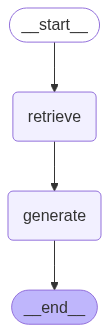

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### __Usage__

LangGraph supports multiple invocation modes, including sync, async, and streaming.

Invoke

In [ ]:
result = graph.invoke({"question": "Dame información sobre la fortificación ibérica de Giribaile"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

2025-07-16 14:48:22,646 - INFO - HTTP Request: POST http://localhost:6333/collections/idearq/points/query "HTTP/1.1 200 OK"


--- Ejecutando nodo: retrieve ---
Buscando documentos para la pregunta: 'Dame información sobre la fortificación ibérica de Giribaile'
Se encontraron 6 documentos
Documento más similar (score: 0.7195):
  Fuente: pdf_articulos_idearq\1148_Fortificacion_2021.pdf
  Contenido (inicio): 'acerca de aspectos relacionados con el supuesto carácter unitario del sistema defensivo y 
Figura 1.  Localización de Giribaile, en el pago de Cástulo.
L. M. Gutiérrez et al. ¿La fortificación ibérica de Giribaile? Caracterización formal e interpret...'

--- Ejecutando nodo: generate ---
Generando respuesta del LLM...


2025-07-16 14:48:43,308 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


Context: [Document(metadata={'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign CC 2015 (Macintosh)', 'creationdate': '2021-06-21T17:24:32+02:00', 'source': 'pdf_articulos_idearq\\1148_Fortificacion_2021.pdf', 'file_path': 'pdf_articulos_idearq\\1148_Fortificacion_2021.pdf', 'total_pages': 26, 'format': 'PDF 1.4', 'title': '¿La fortificación ibérica de Giribaile? Caracterización formal e interpretación arquitectónica de la muralla de cajones', 'author': 'Gutiérrez Soler, Luis María', 'subject': '', 'keywords': 'EDAD DEL HIERRO, PROTOHISTORIA MEDITERRÁNEA, GUADALQUIVIR, POLIORCÉTICA, SIERRA MORENA, SEGUNDA GUERRA PÚNICA', 'moddate': '2021-06-21T17:27:12+02:00', 'trapped': '', 'modDate': "D:20210621172712+02'00'", 'creationDate': "D:20210621172432+02'00'", 'start_index': 6526, '_id': '6893b244-a8ce-4757-b8cc-028655b23e30', '_collection_name': 'idearq'}, page_content='acerca de aspectos relacionados con el supuesto carácter unitario del sistema defensivo y \nFigura 1.\u2003 

Esta respuesta lleva a pensar que se necesita utilizar otro prompt.

In [12]:
from langchain_core.prompts import ChatPromptTemplate

template = """
Eres un asistente experto en arqueología, historia e información geoespacial.
Tu tarea es responder a la pregunta del usuario basándote **única y exclusivamente** en el siguiente contexto proporcionado.

No utilices ningún conocimiento previo. Si la información no se encuentra en el contexto, responde exactamente: 
"La información solicitada no se encuentra en los documentos proporcionados."

Contexto:
{context}

Pregunta:
{question}

Respuesta concisa y útil:
"""

prompt = ChatPromptTemplate.from_template(template)

example_messages = prompt.invoke(
    {"context": "Aquí irían los documentos sobre Giribaile...", "question": "¿Qué sabes sobre la fortificación ibérica de Giribaile?"}
).to_messages()

print("--- Estructura del nuevo prompt ---")
print(example_messages[0].content)


--- Estructura del nuevo prompt ---

Eres un asistente experto en arqueología, historia e información geoespacial.
Tu tarea es responder a la pregunta del usuario basándote **única y exclusivamente** en el siguiente contexto proporcionado.

No utilices ningún conocimiento previo. Si la información no se encuentra en el contexto, responde exactamente: 
"La información solicitada no se encuentra en los documentos proporcionados."

Contexto:
Aquí irían los documentos sobre Giribaile...

Pregunta:
¿Qué sabes sobre la fortificación ibérica de Giribaile?

Respuesta concisa y útil:



In [16]:
# Modelo de Embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
print("Modelo de Embeddings inicializado")

Modelo de Embeddings inicializado


In [17]:
from langchain_qdrant import Qdrant

client = QdrantClient(url="http://localhost:6333")
vector_store = Qdrant(
    client=client, 
    collection_name="idearq", 
    embeddings=embeddings,
)
print("Conexión a Qdrant establecida con éxito")

Conexión a Qdrant establecida con éxito


C:\Users\elevi\AppData\Local\Temp\ipykernel_11680\446272639.py:4: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.1.2 and will be removed in 0.5.0. Use :class:`~QdrantVectorStore` instead.
  vector_store = Qdrant(


In [18]:
result = graph.invoke({"question": "Dame información sobre la fortificación ibérica de Giribaile"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

--- Ejecutando nodo: retrieve ---
Buscando documentos para la pregunta: 'Dame información sobre la fortificación ibérica de Giribaile'
Se encontraron 6 documentos
Documento más similar (score: 0.0000):
  Fuente: pdf_articulos_idearq\1000_oms_2017.pdf
  Contenido (inicio): 'Lab. reference
δ13
BP
Var.
Cal BC 2σ
References
Bonica IV2
Catalonia
Spain
6
Human bone
OxA-29639
19.19
6351
35
5466–5226
Present study
Bonica IV2
Catalonia
Spain
Human bone
Beta-384726
18.7
6390
30
5468–5316
Present study
Bonica IV2
Catalonia
Spain...'

--- Ejecutando nodo: generate ---


NotImplementedError: 

In [51]:
import json
# NUEVA MANERA
result = graph.invoke({"question": "Dame información sobre la fortificación ibérica de Giribaile"})
print(json.dumps(result["answer"], indent=2))

--- Ejecutando nodo: retrieve ---
Buscando documentos para la pregunta: 'Dame información sobre la fortificación ibérica de Giribaile'


2025-07-17 14:56:59,225 - INFO - HTTP Request: POST http://localhost:6333/collections/idearq/points/query "HTTP/1.1 500 Internal Server Error"


UnexpectedResponse: Unexpected Response: 500 (Internal Server Error)
Raw response content:
b'{"status":{"error":"Service internal error: 1 of 1 read operations failed:\\n  Service internal error: task 181 panicked with message \\"called `Result::unwrap()` on an `Err` value: OutputTooSmall {  ...'

probar este modelo de embbeding: sentence-transformers/all-mpnet-base-v2

https://python.langchain.com/docs/how_to/graph_constructing/
https://python.langchain.com/docs/how_to/query_multiple_queries/
https://python.langchain.com/docs/how_to/chatbots_memory/
https://python.langchain.com/docs/how_to/qa_citations/
https://python.langchain.com/docs/how_to/qa_sources/
https://python.langchain.com/docs/how_to/message_history/
https://python.langchain.com/docs/integrations/chat/
https://python.langchain.com/docs/how_to/message_history/

In [ ]:
import os
import sys
import json
import pprint
from dotenv import load_dotenv
from typing import List, Optional

# --- LangChain y Componentes ---
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Qdrant
from langchain_community.llms import Ollama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document

# --- LangGraph ---
from langgraph.graph import START, END, StateGraph

# --- Pydantic para Estructura de Datos ---
from pydantic import BaseModel, Field

# --- Cliente de Qdrant ---
from qdrant_client import QdrantClient

# Cargar variables de entorno (p. ej. LANGSMITH_API_KEY)
load_dotenv()
print("Variables de entorno cargadas.")

# --- INICIALIZAR COMPONENTES ---

# 1. LLM (Asegúrate de que Ollama esté sirviendo el modelo)
llm = Ollama(model="hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0")
print("LLM inicializado.")

# 2. Modelo de Embeddings
# Usamos HuggingFaceEmbeddings que es la integración estándar de LangChain
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
print("Modelo de Embeddings inicializado.")

# 3. Conexión a la Vector Store existente en Qdrant
# NO se crea una nueva, solo nos conectamos a la que ya tiene los datos.
client = QdrantClient(url="http://localhost:6333")
vector_store = Qdrant(
    client=client, 
    collection_name="idearq", 
    embeddings=embeddings,
)
print("Conexión a Qdrant establecida con éxito.")


In [ ]:
# --- DEFINIR EL ESTADO DEL GRAFO ---

class AnswerWithSources(BaseModel):
    """Una respuesta a la pregunta, con sus fuentes."""
    answer: str = Field(description="La respuesta concisa y directa a la pregunta del usuario.")
    sources: List[str] = Field(
        description="Lista de las fuentes (metadata['source']) de los documentos usados para construir la respuesta."
    )

class State(BaseModel):
    """Representa el estado de nuestro grafo."""
    question: str
    context: List[Document] = Field(default_factory=list)
    answer: Optional[AnswerWithSources] = None

# --- DEFINIR EL PROMPT ---

template = """
Eres un asistente experto en arqueología, historia e información geoespacial.
Tu tarea es responder a la pregunta del usuario basándote **única y exclusivamente** en el siguiente contexto proporcionado.

No utilices ningún conocimiento previo. Si la información no se encuentra en el contexto, responde exactamente: 
"La información solicitada no se encuentra en los documentos proporcionados."

Contexto:
{context}

Pregunta:
{question}

Respuesta concisa y útil:
"""
prompt = ChatPromptTemplate.from_template(template)


In [ ]:
# --- DEFINIR LOS NODOS DEL GRAFO ---

def retrieve(state: State):
    """Recupera documentos de la base de datos vectorial."""
    print("--- Ejecutando nodo: retrieve ---")
    question = state.question
    
    # Usamos el vector_store definido globalmente
    retrieved_docs = vector_store.similarity_search(question, k=6)
    
    print(f"Se encontraron {len(retrieved_docs)} documentos.")
    return {"context": retrieved_docs}

def generate(state: State):
    """Genera una respuesta usando el contexto y la pregunta."""
    print("--- Ejecutando nodo: generate ---")
    context = state.context
    question = state.question

    if not context:
        print("ADVERTENCIA: No hay contexto para generar una respuesta.")
        return {"answer": AnswerWithSources(answer="No se recuperó información para responder.", sources=[])}

    docs_content = "\\n\\n".join([doc.page_content for doc in context])
    
    # Preparamos el LLM para que la salida tenga el formato de AnswerWithSources
    structured_llm = llm.with_structured_output(AnswerWithSources)
    
    # Creamos el prompt con la información
    messages = prompt.invoke({"question": question, "context": docs_content})
    
    # Invocamos al LLM
    response = structured_llm.invoke(messages)
    return {"answer": response}

# --- CONSTRUIR EL GRAFO ---

graph_builder = StateGraph(State)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

print("Grafo compilado y listo para usar.")


In [ ]:
# --- INVOCAR EL GRAFO CON TU PREGUNTA ---

pregunta_usuario = "Dame información sobre la fortificación ibérica de Giribaile"

# El grafo se ejecuta y va pasando por los nodos definidos
result = graph.invoke({"question": pregunta_usuario})

# Usamos pprint para una salida más limpia del objeto Pydantic
print("\\n--- RESPUESTA FINAL ---")
pprint.pprint(result["answer"])
